In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xml.etree.ElementTree as ET
import random
import shutil
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## Data pipelining

In [2]:
data_dir = os.getcwd()
img_dir = os.path.join(data_dir, 'images')
ann_dir = os.path.join(data_dir, 'annotations')
ann_dir = os.path.join(ann_dir, 'xmls')

In [3]:
ann_names = {i.split('.')[0] for i in os.listdir(ann_dir)}
img_names = {i.split('.')[0] for i in os.listdir(img_dir)}
final_img_names = sorted([i+'.jpg' for i in list(ann_names.intersection(img_names))])
print(len(final_img_names))
vfl_image_names = ['VFL_'+i for i in final_img_names]
hfl_image_names = ['HFL_'+i for i in final_img_names]
final_img_names.extend(vfl_image_names)
final_img_names.extend(hfl_image_names)
print(len(final_img_names))

train_size = int(len(final_img_names) * 0.8)
val_size = len(final_img_names) - train_size

all_image_names = final_img_names.copy()
random.seed(42)
random.shuffle(all_image_names)

train_image_names = all_image_names[:train_size]
val_image_names = all_image_names[train_size:]

print(len(train_image_names), len(val_image_names))


3685
11055
8844 2211


In [4]:
def parse_annotation(ann_path, flip_h=False, flip_v=False):
    root = ET.parse(ann_path).getroot()
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    obj = root.find('object')
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    if flip_h:
        xmin, xmax = width - xmax, width - xmin
    if flip_v:
        ymin, ymax = height - ymax, height - ymin
    bbox = np.array([xmin/width, ymin/height, xmax/width, ymax/height]).astype('float32')
    return bbox


# Define a function to create the target labels for bounding box prediction
def create_target_boxes(data_dir, image_names):
    boxes = []
    for image_name in image_names:
        flip_h = (image_name[:4]=='HFL_')
        flip_v = (image_name[:4]=='VFL_')
        if (flip_h or flip_v):
            image_name = image_name[4:]
        ann_path = os.path.join(ann_dir, (image_name.replace('.jpg','.xml')))
        box = parse_annotation(ann_path, flip_h, flip_v)
        boxes.append(box)
    return np.stack(boxes)


# Create the target labels for bounding box prediction
train_target_boxes = create_target_boxes(data_dir, train_image_names)
val_target_boxes = create_target_boxes(data_dir, val_image_names)
print(train_target_boxes.shape)
print(len(train_image_names))
print(val_target_boxes.shape)
print(len(val_image_names))

(8844, 4)
8844
(2211, 4)
2211


In [5]:
def im_array(directory, names):
    im_list = []
    for name in names:
        im = Image.open(os.path.join(directory, name)).convert('L')
        im = im.resize((224,224))
        im_ar = np.array(im).astype('float32')
        im_ar /= 255.0
        im_list.append(im_ar)
    images = np.array(im_list)
    return images


def vgg_im_array(directory, names):
    im_list = []
    for name in names:
        im = Image.open(os.path.join(directory, name)).convert('L')
        im = im.resize((224,224))
        im_rgb = Image.merge('RGB', (im, im, im))  # Convert the grayscale image to RGB
        im_ar = np.array(im_rgb).astype('float32')
        im_ar /= 255.0
        im_list.append(im_ar)
    images = np.array(im_list)
    return images


train_array = im_array(img_dir, train_image_names)
val_array = im_array(img_dir, val_image_names)
print(train_array.shape, train_target_boxes.shape)
print(val_array.shape, val_target_boxes.shape)

(8844, 224, 224) (8844, 4)
(2211, 224, 224) (2211, 4)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## BM

In [170]:
model_big = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_big.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [147]:
history_big = model_big.fit(train_array, train_target_boxes, epochs=9, 
                    validation_data=(val_array, val_target_boxes))

Epoch 1/10
277/277 [==============================] - 905s 3s/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 2/10
277/277 [==============================] - 866s 3s/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 3/10
277/277 [==============================] - 883s 3s/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 4/10
277/277 [==============================] - 868s 3s/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 5/10
277/277 [==============================] - 872s 3s/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 6/10
277/277 [==============================] - 866s 3s/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 7/10
277/277 [==

In [148]:
model_big.save('big_model_8epoch.h5')

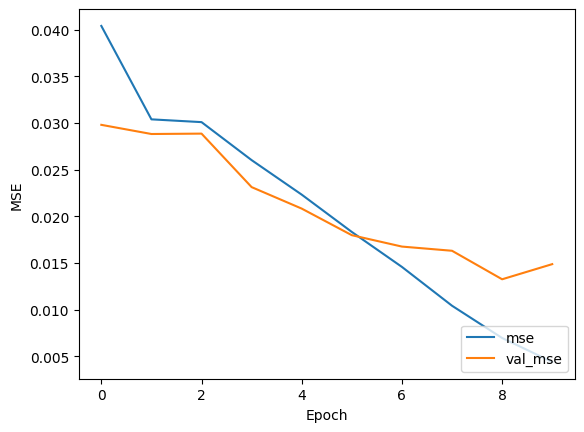

In [149]:
# Plot the MSE
plt.plot(history_big.history['mean_squared_error'], label='mse')
plt.plot(history_big.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

## BMP

In [171]:
model_big_pad = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_big_pad.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])


In [173]:
history_big_pad = model_big_pad.fit(train_array, train_target_boxes, epochs=10, 
                    validation_data=(val_array, val_target_boxes))

Epoch 1/10
277/277 [==============================] - 1303s 5s/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 2/10
277/277 [==============================] - 1273s 5s/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 3/10
277/277 [==============================] - 1252s 5s/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 4/10
277/277 [==============================] - 1250s 5s/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 5/10
277/277 [==============================] - 1332s 5s/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 6/10
277/277 [==============================] - 1074s 4s/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 7/10
277/2

In [191]:
model_big_pad.save('big_model_pad_10epoch.h5')

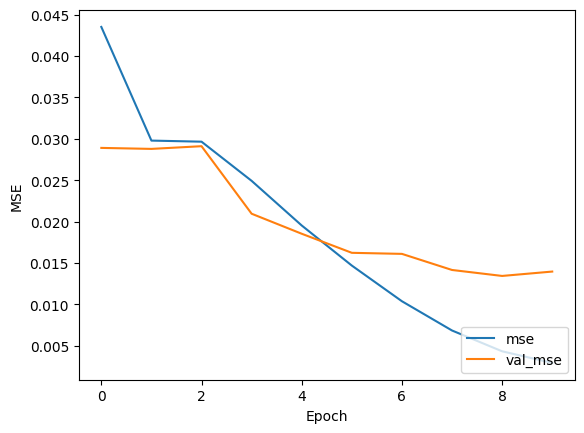

In [184]:
# Plot the MSE
plt.plot(history_big_pad.history['mean_squared_error'], label='mse')
plt.plot(history_big_pad.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

## BMAD

In [150]:
model_big_drop = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_big_drop.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])


In [151]:
history_big_drop = model_big_drop.fit(train_array, train_target_boxes, epochs=10, 
                    validation_data=(val_array, val_target_boxes))

Epoch 1/10
277/277 [==============================] - 899s 3s/step - loss: 0.0552 - mean_squared_error: 0.0552 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 2/10
277/277 [==============================] - 881s 3s/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 3/10
277/277 [==============================] - 887s 3s/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 4/10
277/277 [==============================] - 884s 3s/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 5/10
277/277 [==============================] - 884s 3s/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 6/10
277/277 [==============================] - 864s 3s/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 7/10
277/277 [==

In [152]:
model_big_drop.save('big_model_drop_10epoch.h5')

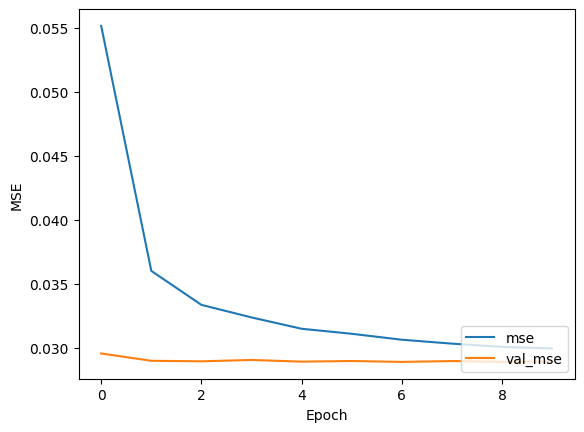

In [153]:
# Plot the MSE
plt.plot(history_big_drop.history['mean_squared_error'], label='mse')
plt.plot(history_big_drop.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

## BMDD

In [158]:
model_big_less_drop = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
#     Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
#     Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
#     Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_big_less_drop.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])


In [159]:
history_big_less_drop = model_big_less_drop.fit(train_array, train_target_boxes, epochs=10, 
                    validation_data=(val_array, val_target_boxes))

Epoch 1/10
277/277 [==============================] - 914s 3s/step - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 2/10
277/277 [==============================] - 859s 3s/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 3/10
277/277 [==============================] - 846s 3s/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 4/10
277/277 [==============================] - 858s 3s/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 5/10
277/277 [==============================] - 957s 3s/step - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 6/10
277/277 [==============================] - 839s 3s/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 7/10
277/277 [==

In [160]:
model_big_less_drop.save('big_model_drop_10epoch.h5')

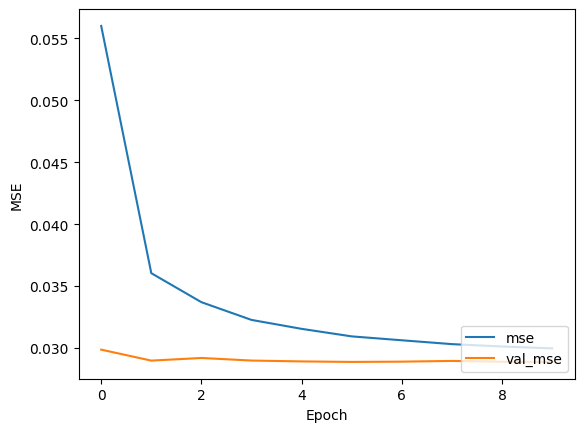

In [161]:
# Plot the MSE
plt.plot(history_big_less_drop.history['mean_squared_error'], label='mse')
plt.plot(history_big_less_drop.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

## BMPDD

In [186]:
model_dense_drop_pad = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_dense_drop_pad.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [187]:
history_dense_drop_pad = model_dense_drop_pad.fit(train_array, train_target_boxes, epochs=10, 
                    validation_data=(val_array, val_target_boxes))

Epoch 1/10
277/277 [==============================] - 1178s 4s/step - loss: 0.0915 - mean_squared_error: 0.0915 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 2/10
277/277 [==============================] - 1099s 4s/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 3/10
277/277 [==============================] - 1084s 4s/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 4/10
277/277 [==============================] - 1096s 4s/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 5/10
277/277 [==============================] - 1110s 4s/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 6/10
277/277 [==============================] - 1180s 4s/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 7/10
277/2

In [188]:
model_dense_drop_pad.save('model_dense_drop_pad_10epoch.h5')

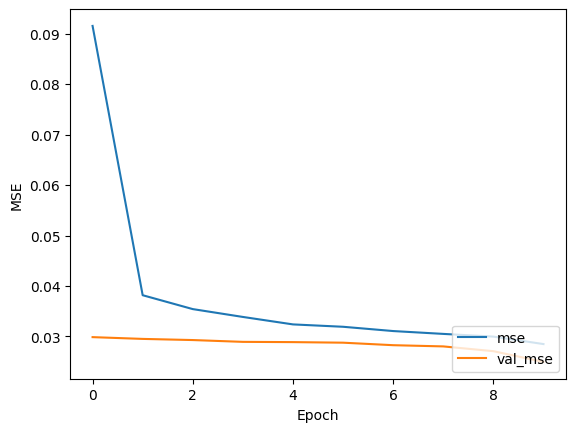

<Figure size 640x480 with 0 Axes>

In [190]:
# Plot the MSE
plt.plot(history_dense_drop_pad.history['mean_squared_error'], label='mse')
plt.plot(history_dense_drop_pad.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()
plt.savefig('dense_drop_pad.png')

## BMPCD

In [7]:
BMPCD = tf.keras.models.load_model('conv_drop_pad_10epoch.h5')

In [4]:
# For r-square

from sklearn.metrics import r2_score

# Evaluate model on test databest R2 
loss, accuracy = BMPCD.evaluate(val_array, val_target_boxes)
# Make predictions on test data
y_pred = BMPCD.predict(val_array)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('R2 score:', r2)

NameError: name 'val_array' is not defined

In [8]:
# For IOU
predictions = BMPCD.predict(val_array)

70/70 [==============================] - 72s 1s/step


In [9]:
iou = []
for i in range(predictions.shape[0]): 
    x1_pred, y1_pred, x2_pred, y2_pred = predictions[i]
    x1_tar, y1_tar, x2_tar, y2_tar = val_target_boxes[i] 
    
    # Calculate the area of predicted and target bounding boxes
    area_pred = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    area_tar = (x2_tar - x1_tar) * (y2_tar - y1_tar)
    
    # Calculate the coordinates of intersection rectangle
    x1_inter = max(x1_pred, x1_tar)
    y1_inter = max(y1_pred, y1_tar)
    x2_inter = min(x2_pred, x2_tar)
    y2_inter = min(y2_pred, y2_tar)
    
    # Calculate the area of intersection rectangle
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    
    # Calculate the IoU score
    iou_score = inter_area / float(area_pred + area_tar - inter_area)
    iou.append(iou_score)

iou = np.array(iou)
np.mean(iou)

0.5095928398150361

## BMDD

In [ ]:
model_dense_drop_pad = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_dense_drop_pad.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

history_dense_drop_pad = model_dense_drop_pad.fit(train_array, train_target_boxes, epochs=10, 
                    validation_data=(val_array, val_target_boxes))

model_dense_drop_pad.save('model_dense_drop_pad_10epoch.h5')

# Plot the MSE
plt.plot(history_dense_drop_pad.history['mean_squared_error'], label='mse')
plt.plot(history_dense_drop_pad.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

## BMCD

In [ ]:

model_big_conv_drop = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
#     Dropout(0.3),
    Dense(128, activation='relu'),
#     Dropout(0.3),
    Dense(64, activation='relu'),
#     Dropout(0.2),
    Dense(32, activation='relu'),
#     Dropout(0.2),
    Dense(4) # Output layer with 4 neurons to predict the bounding box coordinates
])

model_big_conv_drop.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [ ]:
history_big_conv_drop = model_big_conv_drop.fit(train_array, train_target_boxes, epochs=10, 
                    validation_data=(val_array, val_target_boxes))

In [ ]:
model_big.save('big_model_10epoch.h5')

## BMVGG

In [ ]:
# model_vgg16 = Sequential([
#     Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2), strides=(2, 2)),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2), strides=(2, 2)),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2), strides=(2, 2)),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2), strides=(2, 2)),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     Conv2D(512, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D((2, 2), strides=(2, 2)),
#     Flatten(),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(4) # Using linear activation for bounding box regression
# ])

# model_vgg.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

In [ ]:
# history_model_vgg = model_vgg.fit(train_array, train_target_boxes, epochs=10, 
#                     validation_data=(val_array, val_target_boxes))

In [200]:
# model_vgg.save('model_vgg_10epoch.h5')
BMVGG = tf.keras.models.load_model('vgg_model_10epoch.h5')

In [199]:
model_vgg.__str__()

'<keras.engine.sequential.Sequential object at 0x000001B5F36BBD00>'

In [ ]:
# Plot the MSE
plt.plot(history_model_vgg.history['mean_squared_error'], label='mse')
plt.plot(history_model_vgg.history['val_mean_squared_error'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()

## Compare Results

In [177]:
model_big = tf.keras.models.load_model('big_model_10epoch.h5')

HFL_yorkshire_terrier_164.jpg
1/1 [==============================] - 0s 106ms/step
[[0.30713987 0.08049162 0.7505703  0.5017371 ]]
[[0.30713987350463867, 0.08049161732196808, 0.7505702972412109, 0.501737117767334]]


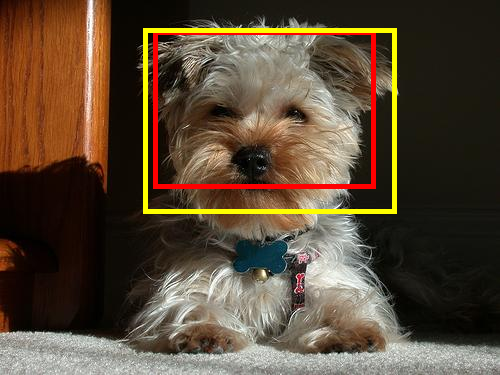

1/1 [==============================] - 1s 590ms/step
[[0.30027536 0.19210382 0.6712937  0.61034894]]
[[0.30027535557746887, 0.1921038180589676, 0.6712936758995056, 0.6103489398956299]]


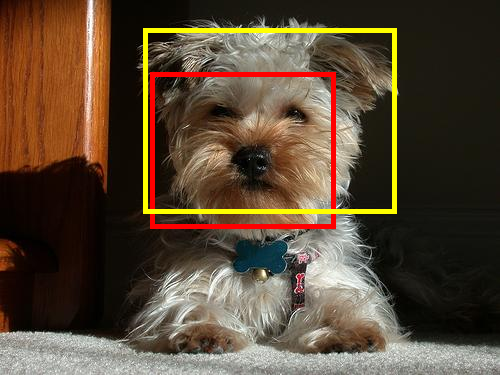

basset_hound_184.jpg
1/1 [==============================] - 0s 108ms/step
[[0.28280705 0.36409205 0.8370155  0.75514954]]
[[0.28280705213546753, 0.36409205198287964, 0.8370155096054077, 0.7551495432853699]]


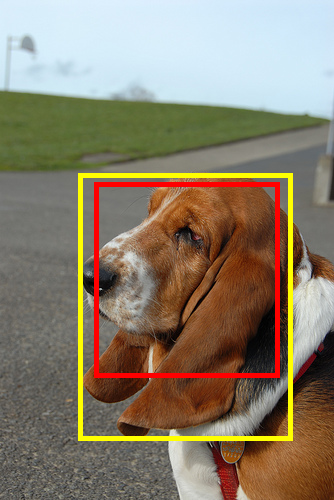

1/1 [==============================] - 0s 274ms/step
[[0.27544197 0.22004868 0.7306925  0.70700896]]
[[0.275441974401474, 0.2200486809015274, 0.7306925058364868, 0.707008957862854]]


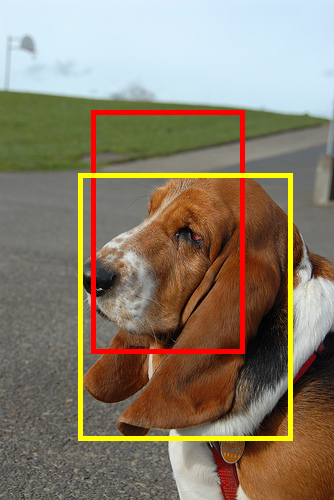

HFL_american_pit_bull_terrier_163.jpg
1/1 [==============================] - 0s 110ms/step
[[0.42139965 0.18695259 0.6673667  0.63556063]]
[[0.42139965295791626, 0.1869525909423828, 0.6673666834831238, 0.6355606317520142]]


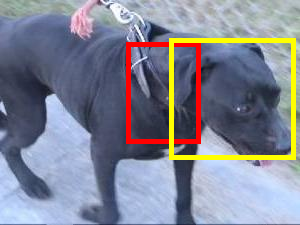

1/1 [==============================] - 0s 265ms/step
[[0.2825617 0.2514737 0.7216306 0.7215356]]
[[0.28256168961524963, 0.25147369503974915, 0.7216305732727051, 0.7215356230735779]]


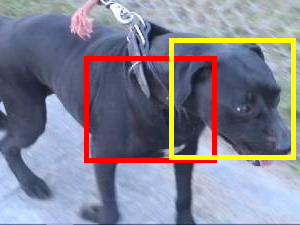

english_setter_153.jpg
1/1 [==============================] - 0s 107ms/step
[[0.11699437 0.12096067 0.40809023 0.4009118 ]]
[[0.11699436604976654, 0.12096066772937775, 0.4080902338027954, 0.400911808013916]]


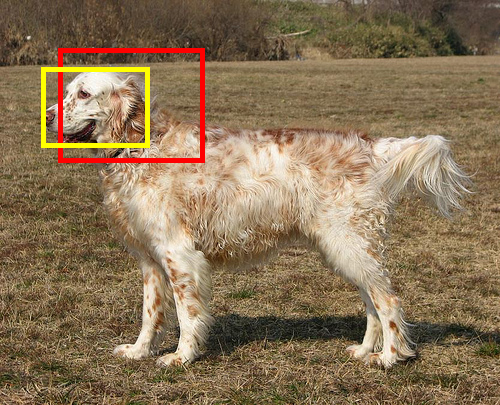

1/1 [==============================] - 0s 271ms/step
[[0.30537015 0.23387158 0.66870433 0.6413944 ]]
[[0.30537015199661255, 0.23387157917022705, 0.6687043309211731, 0.6413943767547607]]


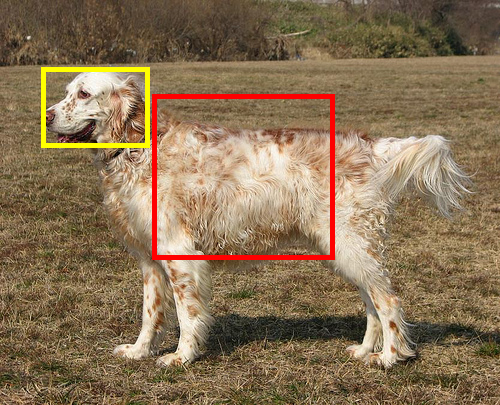

boxer_149.jpg
1/1 [==============================] - 0s 108ms/step
[[0.3863804 0.3887413 0.6717137 0.6776169]]
[[0.3863804042339325, 0.38874131441116333, 0.6717137098312378, 0.6776168942451477]]


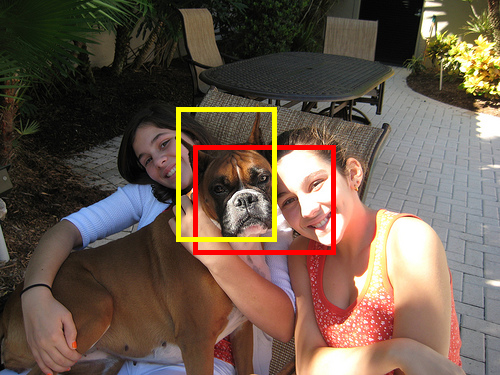

1/1 [==============================] - 0s 247ms/step
[[0.28847063 0.25661647 0.7098794  0.71116596]]
[[0.28847062587738037, 0.256616473197937, 0.7098793983459473, 0.7111659646034241]]


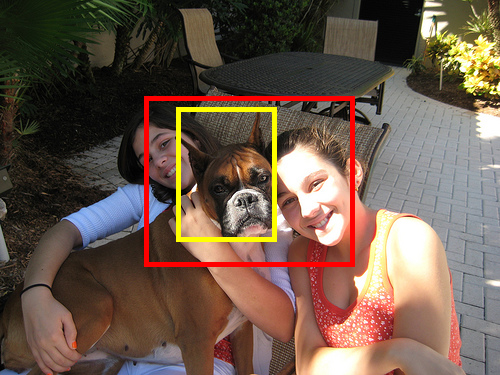

VFL_great_pyrenees_127.jpg
1/1 [==============================] - 0s 114ms/step
[[0.49286205 0.40559036 0.65942526 0.6482119 ]]
[[0.4928620457649231, 0.40559035539627075, 0.6594252586364746, 0.6482118964195251]]


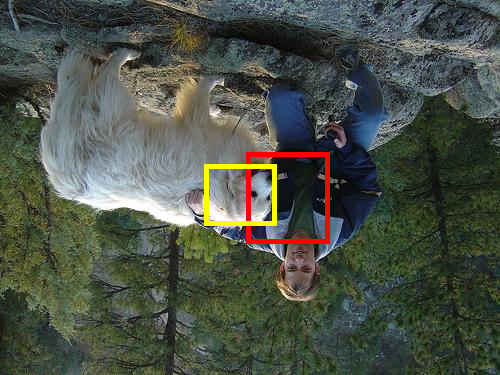

1/1 [==============================] - 0s 278ms/step
[[0.30653092 0.2606808  0.67160815 0.66698945]]
[[0.3065309226512909, 0.26068079471588135, 0.6716081500053406, 0.6669894456863403]]


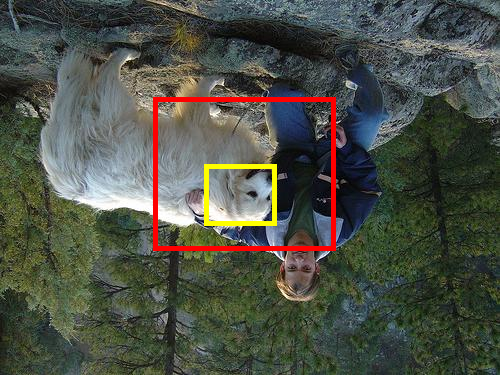

VFL_beagle_185.jpg
1/1 [==============================] - 0s 105ms/step
[[0.1479661  0.22362952 0.6305484  0.5709379 ]]
[[0.14796610176563263, 0.22362951934337616, 0.6305484175682068, 0.5709378719329834]]


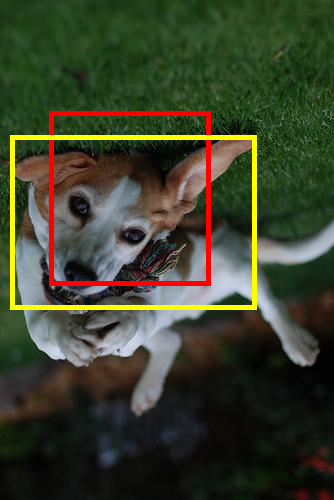

1/1 [==============================] - 0s 249ms/step
[[0.3045472  0.31351587 0.68657666 0.72890925]]
[[0.30454719066619873, 0.31351587176322937, 0.6865766644477844, 0.7289092540740967]]


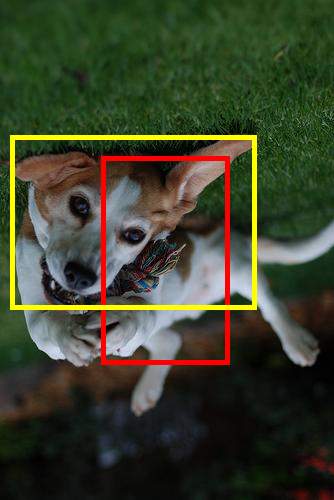

HFL_Egyptian_Mau_170.jpg
1/1 [==============================] - 0s 111ms/step
[[0.3455345  0.30602327 0.60109127 0.56408703]]
[[0.3455345034599304, 0.3060232698917389, 0.6010912656784058, 0.5640870332717896]]


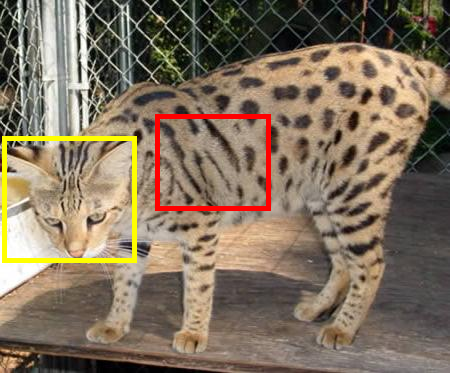

1/1 [==============================] - 0s 282ms/step
[[0.30027536 0.19210382 0.6712937  0.61034894]]
[[0.30027535557746887, 0.1921038180589676, 0.6712936758995056, 0.6103489398956299]]


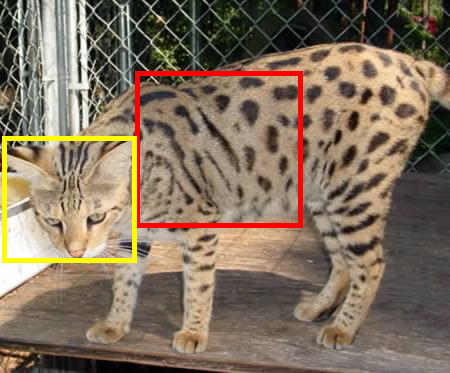

VFL_leonberger_147.jpg
1/1 [==============================] - 0s 107ms/step
[[0.1987778 0.5319213 0.4937488 0.8021843]]
[[0.19877779483795166, 0.5319213271141052, 0.49374881386756897, 0.8021842837333679]]


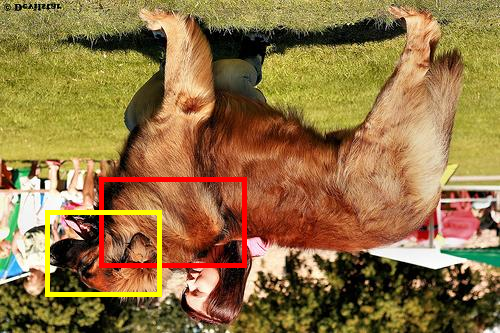

1/1 [==============================] - 0s 266ms/step
[[0.31721073 0.34962237 0.66646063 0.7335533 ]]
[[0.31721073389053345, 0.34962236881256104, 0.6664606332778931, 0.7335532903671265]]


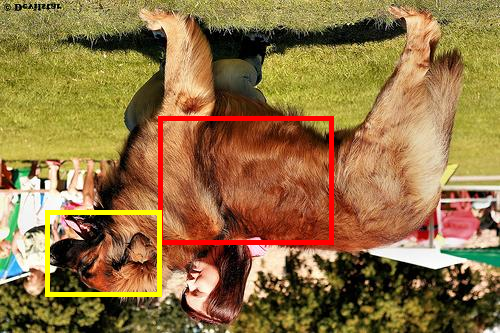

leonberger_147.jpg
1/1 [==============================] - 0s 103ms/step
[[0.09702061 0.070907   0.3641081  0.36434597]]
[[0.09702061116695404, 0.07090699672698975, 0.3641080856323242, 0.3643459677696228]]


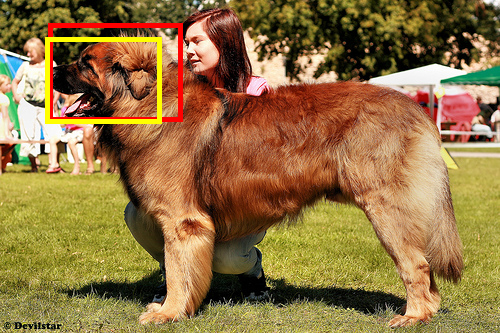

1/1 [==============================] - 0s 259ms/step
[[0.30027536 0.19210382 0.6712937  0.61034894]]
[[0.30027535557746887, 0.1921038180589676, 0.6712936758995056, 0.6103489398956299]]


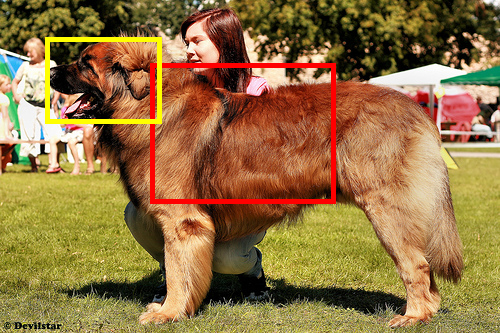

In [206]:
def pred_coordinates(image_name, model, color_flag):

    img_path = os.path.join(img_dir, image_name)
    img = Image.open(img_path).convert('L')
    img = img.resize((224, 224))
    if color_flag:
        img = Image.merge('RGB', (img, img, img))
    img_arr = np.array(img).astype('float32')
    img_arr /= 255.0
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = np.expand_dims(img_arr, axis=-1)
    # Get the predicted bounding box coordinates
    bbox_coords = model.predict(img_arr)
    print(bbox_coords)
    bbox_coords = bbox_coords.tolist()
    return bbox_coords


def parse_annotation_test(ann_path, flip_h=False, flip_v=False):
    root = ET.parse(ann_path).getroot()
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    obj = root.find('object')
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    if flip_h:
        xmin, xmax = width - xmax, width - xmin
    if flip_v:
        ymin, ymax = height - ymax, height - ymin
    bbox = np.array([xmin, ymin, xmax, ymax, width, height]).astype('float32')
    return bbox


def create_target_boxes_test(data_dir, image_names):
    for image_name in image_names:
        flip_h = (image_name[:4]=='HFL_')
        flip_v = (image_name[:4]=='VFL_')
        if (flip_h or flip_v):
            image_name = image_name[4:]
        ann_path = os.path.join(ann_dir, (image_name.replace('.jpg','.xml')))
        box = parse_annotation_test(ann_path, flip_h, flip_v)
#         boxes.append(box)
    return box


def display_result(random_image, model, color_flag=False):

    bbox_coords = pred_coordinates(random_image, model, color_flag)
    print(bbox_coords)
    train_image_names = [random_image]
    train_target_boxes = create_target_boxes_test(data_dir, train_image_names)

    xyxy_true = list(train_target_boxes[:4])

    width = train_target_boxes[4]
    height = train_target_boxes[5]

    xyxy = [bbox_coords[0][0]*width, bbox_coords[0][1]*height,bbox_coords[0][2]*width, bbox_coords[0][3]*height ]
    
    img_path = "images/{}".format(random_image)
    img = Image.open(img_path)

    draw = ImageDraw.Draw(img)
    draw.rectangle(xyxy, outline="red", width = 5)
    draw.rectangle(xyxy_true, outline="yellow", width = 5)

    return display(img)

# Choose a random item from the list
random_images = random.sample(val_image_names, k=3)
random_images = ['HFL_yorkshire_terrier_164.jpg',
'basset_hound_184.jpg', 'HFL_american_pit_bull_terrier_163.jpg', 'english_setter_153.jpg',
'boxer_149.jpg', 'VFL_great_pyrenees_127.jpg',
'VFL_beagle_185.jpg', 'HFL_Egyptian_Mau_170.jpg', 'VFL_leonberger_147.jpg', 'leonberger_147.jpg']
        
for random_image in random_images:
    print(random_image)
    display_result(random_image, BMPCD)
    display_result(random_image, BMVGG, color_flag=True)
    
#     display_result(random_image, model_big_drop) 
#     display_result(random_image, model_big_less_drop) 
    

In [182]:
model_big.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 conv2d_59 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 conv2d_61 (Conv2D)          (None, 106, 106, 64)      36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 53, 53, 64)       0         
 g2D)                                                

In [207]:
BMVGG.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________
